In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installations

In [2]:
!pip install shap

In [3]:
!pip install scikit_optimize

In [4]:
!pip install catboost

In [5]:
!pip install lightgbm

In [6]:
!pip install auto-sklearn 

# Imports

In [7]:
import numpy as np 
import pandas as pd 
import os
from datetime import datetime
import timeit
import pickle
from math import sqrt 

import joblib
# skopt.space.space

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
# from jupyter_dash import JupyterDash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output
# from Dash_converter import checkpoint, experiment

# preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFwe, f_regression, SelectKBest, SelectFdr, chi2, f_classif, mutual_info_classif, SelectFromModel
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer, PolynomialFeatures
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# text mining
import nltk
nltk.download('all-corpora', 'punkt', 'stopwords') # NLP - Download 'all-corpora' and 'punkt' from nltk
from nltk.tokenize import sent_tokenize, word_tokenize, punkt
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re, string
from sklearn.feature_extraction.text import TfidfVectorizer

# decomposition
from sklearn.decomposition import PCA

# Models
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model

from sklearn.linear_model import MultiTaskLasso, PassiveAggressiveClassifier, LogisticRegression, SGDClassifier, Perceptron, LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import explained_variance_score, r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, make_scorer, accuracy_score, confusion_matrix, average_precision_score

from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor

import lightgbm as lgb
import xgboost as xgb
import catboost as ctb

# Hyperparameter tuning
from functools import partial
from skopt.searchcv import BayesSearchCV
from skopt import space 
from skopt.space import Integer, Real, Categorical 
from skopt.utils import use_named_args
from skopt import gp_minimize
# import autosklearn.regression
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, STATUS_FAIL

# XAI
import shap

# To see multiple outputs from a cell
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 20) 

# for convenice check out some jupyter notebook tricks: https://www.kaggle.com/tientd95/jupyter-notebook-tricks

import warnings
warnings.filterwarnings('ignore')

### Set Parameters

In [8]:
random_state = 1
removeNan = True
CURRENT_DIR = 'drive/MyDrive/IE_500_Data_Mining_I/MachineLearning'

In [9]:
# choose dataset
DATASET = ['Input_Data/immo_data.csv',
           # 'Input_Data/df_1_exploratoryDataAnalysis.pkl', # was only applicable in project process
           # 'df_featureSelection.pkl' # was only applicable in project process
           ]

DATASET_NUM = 0

In [10]:
def my_custom_score_ev(y_true, y_pred):   
  return explained_variance_score(y_true, y_pred)

def my_custom_score_rmse(y_true, y_pred):  
  return sqrt(mean_squared_error(y_true, y_pred))*(-1) # negative RMSE bc. optimization of models mostly with maximization of scoring function

def my_custom_r2(y_true, y_pred):
  return r2_score(y_true, y_pred)


# Read Data

In [11]:
if DATASET_NUM == 0:
    # read data set
    df = pd.read_csv(os.path.join(CURRENT_DIR,'Input_Data/immo_data.csv'))
    
    # rename reatures
    df.rename(columns={'regio1': 'state', 
                      'regio2': 'district',
                      'regio3': 'city',                              
                      'newlyConst': 'new',
                      'picturecount': 'noPicture', 
                  }, inplace=True)

In [12]:
# was only applicable in project process
if DATASET_NUM == 1:
  # read data set
  df = pd.read_pickle(os.path.join(CURRENT_DIR,'Input_Data/df_1_exploratoryDataAnalysis.pkl'))

# Preprocessing

## Feature Engineering

In [13]:
# # Extract date features
df['date'] = pd.to_datetime(df['date'], format='%b%y')
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)

# Add length of description
df['descriptionLength'] = df['description'].str.len()

# Add length of facilities
df['facilitiesLength'] = df['facilities'].str.len()

# Transform firingTypes to different features (limited by options on immoscout)
df['firingTypes_oil'] = 0
df['firingTypes_windEnergy']  = 0
df['firingTypes_gas'] = 0
df['firingTypes_districtHeating'] = 0
df['firingTypes_pelletHeating'] = 0
df['firingTypes_naturalGasLight'] = 0
df['firingTypes_electricity'] = 0
df['firingTypes_naturalGasHeavy'] = 0
df['firingTypes_solarHeating'] = 0
df['firingTypes_environmentalThermalEnergy'] = 0
df['firingTypes_steamDistinctHeating'] = 0
df['firingTypes_localHeating'] = 0
df['firingTypes_combinedHeatAndPowerRegenerativeEnergy'] = 0
df['firingTypes_heatSupply'] = 0
df['firingTypes_geothermal'] = 0
df['firingTypes_combinedHeatAndPowerFossilFuels'] = 0
df['firingTypes_liquidGas'] = 0
df['firingTypes_combinedHeatAndPowerRenewableEnergy'] = 0
df['firingTypes_bioEnergy'] = 0
df['firingTypes_woodChips'] = 0
df['firingTypes_wood'] = 0
df['firingTypes_hydroEnergy'] = 0
df['firingTypes_coal'] = 0
df['firingTypes_combinedHeatAndPowerBioEnergy'] = 0
df['firingTypes_coalCoke'] = 0

for i in df.index:
  if not pd.isnull(df['firingTypes'][i]):
    if "oil" in df['firingTypes'][i]:
      df['firingTypes_oil'][i] = 1
    if "wind_energy" in df['firingTypes'][i]:
      df['firingTypes_windEnergy'][i] = 1
    if "gas" in df['firingTypes'][i]:
      df['firingTypes_gas'][i] = 1
    if "district_heating" in df['firingTypes'][i]:
      df['firingTypes_districtHeating'][i] = 1
    if "pellet_heating" in df['firingTypes'][i]:
      df['firingTypes_pelletHeating'][i] = 1
    if "natural_gas_light" in df['firingTypes'][i]:
      df['firingTypes_naturalGasLight'][i] = 1
    if "electricity" in df['firingTypes'][i]:
      df['firingTypes_electricity'][i] = 1
    if "natural_gas_heavy" in df['firingTypes'][i]:
      df['firingTypes_naturalGasHeavy'][i] = 1
    if "solar_heating" in df['firingTypes'][i]:
      df['firingTypes_solarHeating'][i] = 1
    if "environmental_thermal_energy" in df['firingTypes'][i]:
      df['firingTypes_environmentalThermalEnergy'][i] = 1
    if "steam_distinct_heating" in df['firingTypes'][i]:
      df['firingTypes_steamDistinctHeating'][i] = 1
    if "local_heating" in df['firingTypes'][i]:
      df['firingTypes_localHeating'][i] = 1
    if "combined_heat_and_power_regenerative_energy" in df['firingTypes'][i]:
      df['firingTypes_combinedHeatAndPowerRegenerativeEnergy'][i] = 1
    if "heat_supply" in df['firingTypes'][i]:
      df['firingTypes_heatSupply'][i] = 1
    if "geothermal" in df['firingTypes'][i]:
      df['firingTypes_geothermal'][i] = 1
    if "combined_heat_and_power_fossil_fuels" in df['firingTypes'][i]:
      df['firingTypes_combinedHeatAndPowerFossilFuels'][i] = 1
    if "liquid_gas" in df['firingTypes'][i]:
      df['firingTypes_liquidGas'][i] = 1
    if "combined_heat_and_power_renewable_energy" in df['firingTypes'][i]:
      df['firingTypes_combinedHeatAndPowerRenewableEnergy'][i] = 1
    if "bio_energy" in df['firingTypes'][i]:
      df['firingTypes_bioEnergy'][i] = 1
    if "wood_chips" in df['firingTypes'][i]:
      df['firingTypes_woodChips'][i] = 1
    if (("wood:" in df['firingTypes'][i]) or (df['firingTypes'][i] == "wood") or (":wood" in df['firingTypes'][i])):
      df['firingTypes_wood'][i] = 1
    if "hydro_energy" in df['firingTypes'][i]:
      df['firingTypes_hydroEnergy'][i] = 1
    if (("coal:" in df['firingTypes'][i]) or (df['firingTypes'][i] == "coal") or (":coal" in df['firingTypes'][i])):
      df['firingTypes_coal'][i] = 1
    if "combined_heat_and_power_bio_energy" in df['firingTypes'][i]:
      df['firingTypes_combinedHeatAndPowerBioEnergy'][i] = 1
    if "coal_coke" in df['firingTypes'][i]:
      df['firingTypes_coalCoke'][i] = 1

## Fill empty values with domain knowlege

In [14]:
# fill easy NaN empty values
df['facilities'] = df['facilities'].fillna('') #NaN values to empty string
df['description'] = df['description'].fillna('') #NaN values to empty string
df['facilitiesLength'] = df['facilitiesLength'].fillna(0) #NaN values to 0 because only NaN if facilites was NaN
df['descriptionLength'] = df['descriptionLength'].fillna(0) #NaN values to 0 because only NaN if description was NaN
df['noParkSpaces'] = df['noParkSpaces'].fillna(0) #Nan values to 0 because 0 not allowed in original dataset and NaN instead

# filling NaN in yearConstructed
for i in df.index:
  if (pd.isnull(df['yearConstructed'][i])):
   if (df['new'][i] == True): #Nan values to publishing date if newly constructed
    df['yearConstructed'][i] = df['year'][i]

# filling NaN in thermalChar
for i in df.index:
  if (pd.isnull(df['thermalChar'][i])):
    if not (pd.isnull(df['energyEfficiencyClass'][i])): # fill thermalChar according to energyEfficiencyClass
      if(df['energyEfficiencyClass'][i] == 'A_PLUS'):
        df['thermalChar'][i] = (df['livingSpace'][i])*15 # according to lower limit per square meter on https://www.dena.de/fileadmin/dena/Dokumente/Pdf/2070_Der_Energieausweis_Gut_informiert_BAU.pdf
      if(df['energyEfficiencyClass'][i] == 'A'):
        df['thermalChar'][i] = (df['livingSpace'][i])*40 # according to lower limit per square meter on https://www.dena.de/fileadmin/dena/Dokumente/Pdf/2070_Der_Energieausweis_Gut_informiert_BAU.pdf
      if(df['energyEfficiencyClass'][i] == 'B'):
        df['thermalChar'][i] = (df['livingSpace'][i])*62.5 # according to lower limit per square meter on https://www.dena.de/fileadmin/dena/Dokumente/Pdf/2070_Der_Energieausweis_Gut_informiert_BAU.pdf
      if(df['energyEfficiencyClass'][i] == 'C'):
        df['thermalChar'][i] = (df['livingSpace'][i])*87.5 # according to lower limit per square meter on https://www.dena.de/fileadmin/dena/Dokumente/Pdf/2070_Der_Energieausweis_Gut_informiert_BAU.pdf
      if(df['energyEfficiencyClass'][i] == 'D'):
        df['thermalChar'][i] = (df['livingSpace'][i])*115 # according to lower limit per square meter on https://www.dena.de/fileadmin/dena/Dokumente/Pdf/2070_Der_Energieausweis_Gut_informiert_BAU.pdf
      if(df['energyEfficiencyClass'][i] == 'E'):
        df['thermalChar'][i] = (df['livingSpace'][i])*145 # according to lower limit per square meter on https://www.dena.de/fileadmin/dena/Dokumente/Pdf/2070_Der_Energieausweis_Gut_informiert_BAU.pdf
      if(df['energyEfficiencyClass'][i] == 'F'):
        df['thermalChar'][i] = (df['livingSpace'][i])*180 # according to lower limit per square meter on https://www.dena.de/fileadmin/dena/Dokumente/Pdf/2070_Der_Energieausweis_Gut_informiert_BAU.pdf
      if(df['energyEfficiencyClass'][i] == 'G'):
        df['thermalChar'][i] = (df['livingSpace'][i])*225 # according to lower limit per square meter on https://www.dena.de/fileadmin/dena/Dokumente/Pdf/2070_Der_Energieausweis_Gut_informiert_BAU.pdf
      if(df['energyEfficiencyClass'][i] == 'H'):
        df['thermalChar'][i] = (df['livingSpace'][i])*250 # according to lower limit per square meter on https://www.dena.de/fileadmin/dena/Dokumente/Pdf/2070_Der_Energieausweis_Gut_informiert_BAU.pdf

## Drop features

In [15]:
if DATASET_NUM == 0:
  # remove too granular location information
  df = df.drop(columns=['city','district', 'houseNumber','street','streetPlain','geo_plz'])

  # remove all columns with price except total rent
  df = df.drop(columns=['baseRent','heatingCosts','serviceCharge']) 

  # remove all columns with duplicate information/bins
  df = df.drop(columns=['firingTypes','geo_bln','geo_krs','noRoomsRange','yearConstructedRange','baseRentRange','livingSpaceRange', 'new', 'energyEfficiencyClass', 'date'])

  # remove useless information 
  df = df.drop(columns=['scoutId'])


## One Hot Encodig for cathegorical values (data wrangeling)

In [16]:
# define features that have to be one-hot-encoded
OneHotEncoding_features = ['state','heatingType','telekomTvOffer','balcony','hasKitchen','cellar','condition','interiorQual','petsAllowed','lift','typeOfFlat','garden',] #zipCode #energyEfficiencyClass # firingTypes

In [17]:
# define features that are one-hot-encoded by nature
OneHotEncoding_features_firingTypes = [
 'firingTypes_oil',
 'firingTypes_windEnergy',
 'firingTypes_gas',
 'firingTypes_districtHeating',
 'firingTypes_pelletHeating',
 'firingTypes_naturalGasLight',
 'firingTypes_electricity',
 'firingTypes_naturalGasHeavy',
 'firingTypes_solarHeating',
 'firingTypes_environmentalThermalEnergy',
 'firingTypes_steamDistinctHeating',
 'firingTypes_localHeating',
 'firingTypes_combinedHeatAndPowerRegenerativeEnergy',
 'firingTypes_heatSupply',
 'firingTypes_geothermal',
 'firingTypes_combinedHeatAndPowerFossilFuels',
 'firingTypes_liquidGas',
 'firingTypes_combinedHeatAndPowerRenewableEnergy',
 'firingTypes_bioEnergy',
 'firingTypes_woodChips',
 'firingTypes_wood',
 'firingTypes_hydroEnergy',
 'firingTypes_coal',
 'firingTypes_combinedHeatAndPowerBioEnergy',
 'firingTypes_coalCoke'                                 
]

In [18]:
# derive numeric features as those that are not and do not have to be one-hot-encoded
numeric_features = []
for i in df.columns:
  if i not in OneHotEncoding_features and i not in OneHotEncoding_features_firingTypes:
    numeric_features.append(i)

# remove target variable from numeric features
numeric_features.remove('totalRent')

#remove textual features from numeric features
numeric_features.remove('description')
numeric_features.remove('facilities')

## Pre-split data cleaning

In [19]:
print(len(df))

df.dropna(subset = ["totalRent"], inplace=True) #remove empty target values

print(len(df))

268850
228333


## Data Splitting

In [20]:
# split data 80/20
y_df = df['totalRent']
X_df = df.drop(['totalRent'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df, test_size=0.2, random_state=random_state)
print(X_train.shape,  X_test.shape )

(182666, 57) (45667, 57)


## Post-split data cleaning

### Train data cleaning

In [21]:
# add x_train and y_train again
y_train_propper_index = pd.DataFrame(y_train).reset_index(drop=True)
X_train_propper_index = X_train.reset_index(drop=True)
train = pd.concat([X_train_propper_index, y_train_propper_index], axis=1) #ignore_index=True

print("Amount of rows before removal: " + str(len(train)))

# Create df to store upper and lower limits
outliers = pd.DataFrame(columns =['Feature', 'Lower', 'Upper'])

# define upper and lower limits based on standard deviation
def outlier_removal_strong(df, variable):
    upper_limit = df[variable].mean() + 0.75 * df[variable].std()
    lower_limit = df[variable].mean() - 0.75 * df[variable].std()
    if lower_limit <0:
      lower_limit = 0 # do not allow for negative values
    return upper_limit, lower_limit

# define features that should be subject to outlier removal
outlier_features_strong = ['totalRent']

# calculate upper and lower limits
for i in outlier_features_strong: 
  upper_limit, lower_limit = outlier_removal_strong(train, i)
  new_row = {'Feature':i, 'Lower':lower_limit, 'Upper':upper_limit}
  outliers = outliers.append(new_row, ignore_index=True)

# outlier removal for every numeric feature was rejected due to worse results
# def outlier_removal_light(df, variable):
#     upper_limit = df[variable].mean() + 3 * df[variable].std()
#     lower_limit = df[variable].mean() - 3 * df[variable].std()
#     if lower_limit <0:
#       lower_limit = 0 # do not allow for negative values
#     return upper_limit, lower_limit

# outlier_features_light = numeric_features 

# for i in outlier_features_light: 
#   upper_limit, lower_limit = outlier_removal_light(train, i)
#   new_row = {'Feature':i, 'Lower':lower_limit, 'Upper':upper_limit}
#   outliers = outliers.append(new_row, ignore_index=True)

# remove outliers based on upper and lower limits
for i in outliers.index:
  feature = outliers['Feature'][i]
  print("")
  print(feature)
  upper = outliers['Upper'][i]
  print("Upper limit: " +str(upper))
  lower = outliers['Lower'][i]
  print("Lower limit: " +str(lower))
  dropped = 0
  for j in train.index:
    if (not pd.isnull(train[feature][j])):
        if ((train[feature][j] < lower) | (train[feature][j] > upper)):
          train.drop(j, inplace=True)
          dropped = dropped+1
  print("Dropped: "+ str(dropped))

print("")
print("Amount of rows remaining after removal: " + str(len(X_train)))

# split x_train and y_train again
y_train = train['totalRent']
X_train = train.drop(['totalRent'],axis=1)

Amount of rows before removal: 182666

totalRent
Upper limit: 28792.582939772066
Lower limit: 0
Dropped: 9

Amount of rows remaining after removal: 182666


### Test data cleaning

In [22]:
# We know, that this is not allowed!
# A test set that includes outliers is retained and bassis for all further evaluation.
# The test set without outliers is only to evaluate the impact of outliers on our test fit.

# add x_train and y_train again
y_test_propper_index = pd.DataFrame(y_test).reset_index(drop=True)
X_test_propper_index = X_test.reset_index(drop=True)
test_wo = pd.concat([X_test_propper_index, y_test_propper_index], axis=1) #ignore_index=True

print("Amount of rows before removal: " + str(len(test_wo)))

# remove outliers based on upper and lower limits derived from training set
for i in outliers.index:
  feature = outliers['Feature'][i]
  print("")
  print(feature)
  upper = outliers['Upper'][i]
  print("Upper limit: " +str(upper))
  lower = outliers['Lower'][i]
  print("Lower limit: " +str(lower))
  dropped = 0
  for j in test_wo.index:
    if (not pd.isnull(test_wo[feature][j])):
        if ((test_wo[feature][j] < lower) | (test_wo[feature][j] > upper)):
          test_wo.drop(j, inplace=True)
          dropped = dropped+1
  print("Dropped: "+ str(dropped))
 
print("")
print("Amount of rows remaining after removal: " + str(len(test_wo)))

# split x_train and y_train again
y_test_wo = test_wo['totalRent']
X_test_wo = test_wo.drop(['totalRent'],axis=1)

Amount of rows before removal: 45667

totalRent
Upper limit: 28792.582939772066
Lower limit: 0
Dropped: 1

Amount of rows remaining after removal: 45666


In [23]:
#separate textual features
X_train_wText = X_train.copy()
X_train = X_train.drop(columns=['description', 'facilities'])
X_test_wText = X_test.copy()
X_test = X_test.drop(columns=['description', 'facilities'])
X_test_wo_wText = X_test_wo.copy()
X_test_wo = X_test_wo.drop(columns=['description', 'facilities'])

# Easy Model

## Without textual information

In [24]:
# impute and standardize numeric data 
numeric_transformer = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy="mean")),
    ('scale', StandardScaler())
])

# impute and encode dummy variables for categorical data
categorical_transformer = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, OneHotEncoding_features)
])

In [25]:
# Run pipeline for every estimator
# Return the R2 for the fit to the train set, test set (incl outliers --> evaluation), and test set without outliers
#######################################################################

pipeline = Pipeline([
    ('transform', preprocessor),
    ('ridge', CatBoostRegressor())
])
print("")
print("CatBoostRegressor")
pipeline.fit(X_train, y_train)
print("Score (Train): "+ str(pipeline.score(X_train, y_train)))

print("Score (Test): "+ str(pipeline.score(X_test, y_test)))
print("Score (Test without Outliers): "+ str(pipeline.score(X_test_wo, y_test_wo))) 

#######################################################################

pipeline = Pipeline([
    ('transform', preprocessor),
    ('ridge', LGBMRegressor())
])
print("")
print("LGBMRegressor")
pipeline.fit(X_train, y_train)
print("Score (Train): "+ str(pipeline.score(X_train, y_train)))

print("Score (Test): "+ str(pipeline.score(X_test, y_test))) 
print("Score (Test without Outliers): "+ str(pipeline.score(X_test_wo, y_test_wo))) 

#######################################################################

pipeline = Pipeline([
    ('transform', preprocessor),
    ('ridge', XGBRegressor(n_jobs = -1))
])
print("")
print("XGBRegressor")
pipeline.fit(X_train, y_train, )
print("Score (Train): "+ str(pipeline.score(X_train, y_train)))

print("Score (Test): "+ str(pipeline.score(X_test, y_test)))
print("Score (Test without Outliers): "+ str(pipeline.score(X_test_wo, y_test_wo))) 

#######################################################################

pipeline = Pipeline([
    ('transform', preprocessor),
    ('ridge', LinearRegression(n_jobs = -1))
])
print("")
print("LinearRegression")
pipeline.fit(X_train, y_train, )
print("Score (Train): "+ str(pipeline.score(X_train, y_train)))

print("Score (Test): "+ str(pipeline.score(X_test, y_test))) 
print("Score (Test without Outliers): "+ str(pipeline.score(X_test_wo, y_test_wo))) 

#######################################################################

pipeline = Pipeline([
    ('transform', preprocessor),
    ('ridge', linear_model.Ridge())
])
print("")
print("Ridge")
pipeline.fit(X_train, y_train, )
print("Score (Train): "+ str(pipeline.score(X_train, y_train)))

print("Score (Test): "+ str(pipeline.score(X_test, y_test))) 
print("Score (Test without Outliers): "+ str(pipeline.score(X_test_wo, y_test_wo))) 

#######################################################################

pipeline = Pipeline([
    ('transform', preprocessor),
    ('ridge', linear_model.ElasticNet(alpha=0.1))
])
print("")
print("ElasticNet")
pipeline.fit(X_train, y_train, )
print("Score (Train): "+ str(pipeline.score(X_train, y_train)))

print("Score (Test): "+ str(pipeline.score(X_test, y_test))) 
print("Score (Test without Outliers): "+ str(pipeline.score(X_test_wo, y_test_wo))) 

#######################################################################

pipeline = Pipeline([
    ('transform', preprocessor),
    ('ridge', linear_model.BayesianRidge())
])
print("")
print("BayesianRidge")
pipeline.fit(X_train, y_train, )
print("Score (Train): "+ str(pipeline.score(X_train, y_train)))

print("Score (Test): "+ str(pipeline.score(X_test, y_test)))
print("Score (Test without Outliers): "+ str(pipeline.score(X_test_wo, y_test_wo))) 

#######################################################################

pipeline = Pipeline([
    ('transform', preprocessor),
    ('ridge', DecisionTreeRegressor())
])
print("")
print("DecisionTreeRegressor")
pipeline.fit(X_train, y_train, )
print("Score (Train): "+ str(pipeline.score(X_train, y_train)))

print("Score (Test): "+ str(pipeline.score(X_test, y_test))) 
print("Score (Test without Outliers): "+ str(pipeline.score(X_test_wo, y_test_wo))) 

#######################################################################

pipeline = Pipeline([
    ('transform', preprocessor),
    ('ridge', RandomForestRegressor(n_jobs = -1))
])
print("")
print("RandomForestRegressor")
pipeline.fit(X_train, y_train, )
print("Score (Train): "+ str(pipeline.score(X_train, y_train)))

print("Score (Test): "+ str(pipeline.score(X_test, y_test))) 
print("Score (Test without Outliers): "+ str(pipeline.score(X_test_wo, y_test_wo))) 

#######################################################################

pipeline = Pipeline([
    ('transform', preprocessor),
    ('ridge', GradientBoostingRegressor())
])
print("")
print("GradientBoostingRegressor")
pipeline.fit(X_train, y_train, )
print("Score (Train): "+ str(pipeline.score(X_train, y_train)))

print("Score (Test): "+ str(pipeline.score(X_test, y_test)))
print("Score (Test without Outliers): "+ str(pipeline.score(X_test_wo, y_test_wo))) 


CatBoostRegressor
Learning rate set to 0.093222
0:	learn: 532.0685410	total: 123ms	remaining: 2m 3s
1:	learn: 503.5850841	total: 162ms	remaining: 1m 20s
2:	learn: 477.6792952	total: 196ms	remaining: 1m 5s
3:	learn: 454.7523854	total: 234ms	remaining: 58.2s
4:	learn: 434.8553503	total: 273ms	remaining: 54.4s
5:	learn: 417.1114138	total: 308ms	remaining: 51s
6:	learn: 400.8410328	total: 346ms	remaining: 49.1s
7:	learn: 386.6639876	total: 383ms	remaining: 47.5s
8:	learn: 374.3166910	total: 419ms	remaining: 46.1s
9:	learn: 363.4782716	total: 464ms	remaining: 45.9s
10:	learn: 353.9072619	total: 498ms	remaining: 44.7s
11:	learn: 345.1728642	total: 532ms	remaining: 43.8s
12:	learn: 337.6554764	total: 567ms	remaining: 43s
13:	learn: 330.9339419	total: 601ms	remaining: 42.3s
14:	learn: 325.0709845	total: 646ms	remaining: 42.4s
15:	learn: 319.5634029	total: 681ms	remaining: 41.9s
16:	learn: 314.7501946	total: 715ms	remaining: 41.4s
17:	learn: 310.0436449	total: 748ms	remaining: 40.8s
18:	learn:

## With textual information

In [26]:
# Merge all textual information together 
X_train_wText['allTexts'] = X_train_wText['description']+" "+X_train_wText['facilities']
X_train_wText = X_train_wText.drop(columns=['description', 'facilities'])
X_test_wText['allTexts'] = X_test_wText['description']+" "+X_test_wText['facilities']
X_test_wText = X_test_wText.drop(columns=['description', 'facilities'])
X_test_wo_wText['allTexts'] = X_test_wo_wText['description']+" "+X_test_wo_wText['facilities']
X_test_wo_wText = X_test_wo_wText.drop(columns=['description', 'facilities'])

In [27]:
#### Tokenization of texts incl. German stopwords & German stemmer ####

# split on whitespace
token_pattern = re.compile(r"(?u)\b\w\w+\b") 

# Function to tokenize - callable from Vectorizer
def tokenize(text):
    # initialize stopwords & stemmer
    my_stopwords = set(stopwords.words('german'))
    stemmer = SnowballStemmer("german")
    stems = []   
    # tokenize
    tokens = token_pattern.findall(text)
    for item in tokens:
        if item not in my_stopwords:
            stems.append(stemmer.stem(item))
    return stems

In [28]:
#### Train vectorizer and create TFIDF matrices for train and test data ####
import nltk
nltk.download('stopwords')

# initialize TFIDF-vectorizer with feature selection: only words that appear in more than 1% and less than 50% of texts (due to high amount of texts and their huge vocabulary)
stem_vec = TfidfVectorizer(tokenizer=tokenize, min_df=0.01, max_df=0.5)

# train TFIDF-vectorizer with 'allTexts' of training data
X_train_tf = stem_vec.fit_transform(X_train_wText['allTexts'])
# transform X_train_wText to TFIDF matrix
X_train_tf = stem_vec.transform(X_train_wText['allTexts'])
X_train_tf = pd.DataFrame(X_train_tf.toarray(), columns=stem_vec.get_feature_names(), index=X_train_wText.index)

# transform X_test_wText to TFIDF matrix
X_test_tf = stem_vec.transform(X_test_wText['allTexts'])
X_test_tf = pd.DataFrame(X_test_tf.toarray(), columns=stem_vec.get_feature_names(), index=X_test_wText.index)

# transform X_test_wo_wText to TFIDF matrix
X_test_wo_tf = stem_vec.transform(X_test_wo_wText['allTexts'])
X_test_wo_tf = pd.DataFrame(X_test_wo_tf.toarray(), columns=stem_vec.get_feature_names(), index=X_test_wo_wText.index)

# rename column 'lift' because we've already feature 'lift'
X_train_tf.rename(columns={"lift": "lift_"}, inplace=True)
X_test_tf.rename(columns={"lift": "lift_"}, inplace=True)
X_test_wo_tf.rename(columns={"lift": "lift_"}, inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
pipeline = Pipeline([
    ('transform', preprocessor),
    ('estimator', LinearRegression())
])

#### Predict target value - only with TFIDF matrix ####
estimator = LinearRegression()
estimator.fit(X_train_tf, y_train)
prediction = estimator.predict(X_test_tf)
print("========== Features: TFIDF matrix ==========================")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
prediction = estimator.predict(X_test_wo_tf)
print("========== with outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction),"\n")

#### Predict target value - only with livingSpace as feature ####
X_train_ls = X_train['livingSpace'].values.reshape(-1, 1)
X_test_ls = X_test['livingSpace'].values.reshape(-1, 1)
estimator.fit(X_train_ls, y_train)
prediction = estimator.predict(X_test_ls)
print("========== Features: livingSpace ===========================")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
X_test_wo_ls = X_test_wo['livingSpace'].values.reshape(-1, 1)
prediction = estimator.predict(X_test_wo_ls)
print("========== with outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction),"\n")

#### Predict target value - with both livingSpace and TFIDF matrix ####
X_train_tf_ls = pd.concat([X_train['livingSpace'], X_train_tf], axis=1)
X_test_tf_ls = pd.concat([X_test['livingSpace'], X_test_tf], axis=1)
estimator.fit(X_train_tf_ls, y_train)
prediction = estimator.predict(X_test_tf_ls)
print("========== Features: livingSpace and TFIDF matrix ==========")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
print("========== with outlier in test data")
X_test_tf_ls = pd.concat([X_test_wo['livingSpace'], X_test_wo_tf], axis=1)
prediction = estimator.predict(X_test_tf_ls)
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction),"\n")

#### Predict target value - all features without TFIDF matrix ####
pipeline = pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)
print("========== Features: alle features without TFIDF matrix =====")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
print("========== with outlier in test data")
prediction = pipeline.predict(X_test_wo)
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction),"\n")

#### Predict target value - with all features and TFIDF matrix ####
X_train_all = pd.concat([X_train, X_train_tf], axis=1)
X_test_all = pd.concat([X_test, X_test_tf], axis=1)
pipeline = pipeline.fit(X_train_all, y_train)
prediction = pipeline.predict(X_test_all)
print("========== Features: all features and TFIDF matrix ==========")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
print("========== with outlier in test data")
X_test_wo_all = pd.concat([X_test_wo, X_test_wo_tf], axis=1)
prediction = pipeline.predict(X_test_wo_all)
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction))

========== Features: TFIDF matrix ==========================
========== without outlier in test data
RMSE: 508.5569449106497
R2: 0.3828448761809382
========== with outlier in test data
RMSE: 416.51898657078135
R2: 0.4803334414841417 

========== Features: livingSpace ===========================
========== without outlier in test data
RMSE: 4801.575292787184
R2: -54.01519375162842
========== with outlier in test data
RMSE: 4792.734118134813
R2: -67.80529123604629 

========== Features: livingSpace and TFIDF matrix ==========
========== without outlier in test data
RMSE: 3167.406531162164
R2: -22.939924468906774
========== with outlier in test data
RMSE: 3153.989287705055
R2: -28.79720932608606 

========== Features: alle features without TFIDF matrix =====
========== without outlier in test data
RMSE: 2980.467772069035
R2: -20.197469563794577
========== with outlier in test data
RMSE: 2966.088878153467
R2: -25.3526008992264 

========== Features: all features and TFIDF matrix ==========

In [30]:
pipeline = Pipeline([
    ('transform', preprocessor),
    ('estimator', CatBoostRegressor())
])

#### Predict target value - only with TFIDF matrix ####
estimator = CatBoostRegressor()
estimator.fit(X_train_tf, y_train)
prediction = estimator.predict(X_test_tf)
print("========== Features: TFIDF matrix ==========================")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
prediction = estimator.predict(X_test_wo_tf)
print("========== with outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction),"\n")

#### Predict target value - only with livingSpace as feature ####
X_train_ls = X_train['livingSpace'].values.reshape(-1, 1)
X_test_ls = X_test['livingSpace'].values.reshape(-1, 1)
estimator.fit(X_train_ls, y_train)
prediction = estimator.predict(X_test_ls)
print("========== Features: livingSpace ===========================")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
X_test_wo_ls = X_test_wo['livingSpace'].values.reshape(-1, 1)
prediction = estimator.predict(X_test_wo_ls)
print("========== with outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction),"\n")

#### Predict target value - with both livingSpace and TFIDF matrix ####
X_train_tf_ls = pd.concat([X_train['livingSpace'], X_train_tf], axis=1)
X_test_tf_ls = pd.concat([X_test['livingSpace'], X_test_tf], axis=1)
estimator.fit(X_train_tf_ls, y_train)
prediction = estimator.predict(X_test_tf_ls)
print("========== Features: livingSpace and TFIDF matrix ==========")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
print("========== with outlier in test data")
X_test_tf_ls = pd.concat([X_test_wo['livingSpace'], X_test_wo_tf], axis=1)
prediction = estimator.predict(X_test_tf_ls)
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction),"\n")

#### Predict target value - all features without TFIDF matrix ####
pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)
print("========== Features: alle features without TFIDF matrix =====")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
print("========== with outlier in test data")
prediction = pipeline.predict(X_test_wo)
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction),"\n")

#### Predict target value - with all features and TFIDF matrix ####
X_train_all = pd.concat([X_train, X_train_tf], axis=1)
X_test_all = pd.concat([X_test, X_test_tf], axis=1)
pipeline.fit(X_train_all, y_train)
prediction = pipeline.predict(X_test_all)
print("========== Features: all features and TFIDF matrix ==========")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
print("========== with outlier in test data")
X_test_all = pd.concat([X_test_wo, X_test_wo_tf], axis=1)
prediction = pipeline.predict(X_test_all)
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction))

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
43:	learn: 415.5753374	total: 25.6s	remaining: 9m 15s
44:	learn: 414.8586675	total: 26.1s	remaining: 9m 12s
45:	learn: 414.1360939	total: 26.6s	remaining: 9m 11s
46:	learn: 413.4483389	total: 27.1s	remaining: 9m 9s
47:	learn: 412.8064762	total: 27.6s	remaining: 9m 7s
48:	learn: 412.1032072	total: 28.2s	remaining: 9m 6s
49:	learn: 411.6197941	total: 28.7s	remaining: 9m 5s
50:	learn: 411.0655062	total: 29.2s	remaining: 9m 3s
51:	learn: 410.5110839	total: 29.8s	remaining: 9m 2s
52:	learn: 410.0286808	total: 30.3s	remaining: 9m
53:	learn: 409.5483150	total: 30.8s	remaining: 9m
54:	learn: 409.0636684	total: 31.4s	remaining: 8m 59s
55:	learn: 408.4964745	total: 31.9s	remaining: 8m 57s
56:	learn: 407.2307725	total: 32.6s	remaining: 8m 58s
57:	learn: 406.6832184	total: 33.1s	remaining: 8m 57s
58:	learn: 406.1836629	total: 33.6s	remaining: 8m 56s
59:	learn: 405.7663397	total: 34.1s	remaining: 8m 54s
60:	learn: 405.3016090	total:

In [31]:
pipeline = Pipeline([
    ('transform', preprocessor),
    ('estimator', LGBMRegressor())
])

#### Predict target value - only with TFIDF matrix ####
estimator = LGBMRegressor()
estimator.fit(X_train_tf, y_train)
prediction = estimator.predict(X_test_tf)
print("========== Features: TFIDF matrix ==========================")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
prediction = estimator.predict(X_test_wo_tf)
print("========== with outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction),"\n")

#### Predict target value - only with livingSpace as feature ####
X_train_ls = X_train['livingSpace'].values.reshape(-1, 1)
X_test_ls = X_test['livingSpace'].values.reshape(-1, 1)
estimator.fit(X_train_ls, y_train)
prediction = estimator.predict(X_test_ls)
print("========== Features: livingSpace ===========================")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
X_test_wo_ls = X_test_wo['livingSpace'].values.reshape(-1, 1)
prediction = estimator.predict(X_test_wo_ls)
print("========== with outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction),"\n")

#### Predict target value - with both livingSpace and TFIDF matrix ####
X_train_tf_ls = pd.concat([X_train['livingSpace'], X_train_tf], axis=1)
X_test_tf_ls = pd.concat([X_test['livingSpace'], X_test_tf], axis=1)
estimator.fit(X_train_tf_ls, y_train)
prediction = estimator.predict(X_test_tf_ls)
print("========== Features: livingSpace and TFIDF matrix ==========")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
print("========== with outlier in test data")
X_test_tf_ls = pd.concat([X_test_wo['livingSpace'], X_test_wo_tf], axis=1)
prediction = estimator.predict(X_test_tf_ls)
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction),"\n")

#### Predict target value - all features without TFIDF matrix ####
pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)
print("========== Features: alle features without TFIDF matrix =====")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
print("========== with outlier in test data")
prediction = pipeline.predict(X_test_wo)
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction),"\n")

#### Predict target value - with all features and TFIDF matrix ####
X_train_all = pd.concat([X_train, X_train_tf], axis=1)
X_test_all = pd.concat([X_test, X_test_tf], axis=1)
pipeline.fit(X_train_all, y_train)
prediction = pipeline.predict(X_test_all)
print("========== Features: all features and TFIDF matrix ==========")
print("========== without outlier in test data")
print("RMSE:", sqrt(mean_squared_error(y_test, prediction)))
print("R2:", r2_score(y_test, prediction))
print("========== with outlier in test data")
X_test_all = pd.concat([X_test_wo, X_test_wo_tf], axis=1)
prediction = pipeline.predict(X_test_all)
print("RMSE:", sqrt(mean_squared_error(y_test_wo, prediction)))
print("R2:", r2_score(y_test_wo, prediction))

========== Features: TFIDF matrix ==========================
========== without outlier in test data
RMSE: 494.88246383803227
R2: 0.415587778152953
========== with outlier in test data
RMSE: 399.691202102147
R2: 0.521475319921935 

========== Features: livingSpace ===========================
========== without outlier in test data
RMSE: 487.45372476672947
R2: 0.4330014520759474
========== with outlier in test data
RMSE: 389.8074092787365
R2: 0.5448491653631858 

========== Features: livingSpace and TFIDF matrix ==========
========== without outlier in test data
RMSE: 415.40594694581097
R2: 0.5882244278865268
========== with outlier in test data
RMSE: 295.5005473466075
R2: 0.7384397502961466 

========== Features: alle features without TFIDF matrix =====
========== without outlier in test data
RMSE: 389.89378029739123
R2: 0.6372497047732342
========== with outlier in test data
RMSE: 256.92807089096317
R2: 0.8022674003798251 

========== Features: all features and TFIDF matrix ==========

# RandomGridSearchCV with Pipelines

In [32]:
random_search_experiment_pipele = True

## Test Score functions

In [33]:
def my_custom_score_ev(y_true, y_pred):
  return explained_variance_score(y_true, y_pred)

def my_custom_score_mse(y_true, y_pred):
  return  mean_squared_error(y_true, y_pred)

def my_custom_r2(y_true, y_pred):
  return r2_score(y_true, y_pred)

## Parameter Space

In [34]:
random_grid_pipelineXGBRegressor = {#'pca__n_components': [0.99,0.95,0.9], #1 means pca is not activated     
  'select_best': [SelectFdr(alpha=0.01),SelectFdr(alpha=0.05),SelectFdr(alpha=0.2), SelectFwe(alpha=0.01),SelectFwe(alpha=0.05),SelectFwe(alpha=0.1)],

  'rf__max_features': ['auto', 'sqrt'], # Number of features to consider at every split
  'rf__max_depth': [3, 5, 6, 10, 15, 20,30,50,80,None], # Maximum number of levels in tree
  'rf__min_samples_split': np.arange(1,15,1), # Minimum number of samples required to split a node
  'rf__min_samples_leaf': np.arange(1,10,1), # Minimum number of samples required at each leaf node
  'rf__bootstrap': [True, False], # Method of selecting samples for training each tree
  'rf__n_estimators': [10,20,50,100,200,400,500],# Number of trees in random forest
  'rf__n_learning_rate': [0.00001, 0.001, 0.01, 0.05, 0.1]
  } 


# https://www.kaggle.com/ihelon/titanic-hyperparameter-tuning-with-gridsearchcv
parameters_xgb = {
    'rf__n_estimators': [100,500,1000]
}
lgb_reg_params = {
    'transform__num__scale':   [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()], #PowerTransformer() sometimes nice results, but a lot of problems
    'rf__learning_rate':    np.arange(0.05, 0.31, 0.05), #[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,0.8],
    'rf__max_depth':        np.arange(5, 16, 1, dtype=int),
    'rf__min_child_weight': np.arange(1, 8, 1, dtype=int),
    'rf__colsample_bytree': np.arange(0.3, 0.8, 0.1),
    'rf__subsample':        [0.8, 1],
    'rf__n_estimators':     [500,1000,2000],#[100,200,400,500],
}
parameters_cat = {
    'rf__iterations': [5, 10, 15, 20, 25, 50, 100],
    'rf__learning_rate': [0.01, 0.05, 0.1],
    'rf__depth': [3, 5, 7, 9, 11, 13],
}

parameters_randomforest = {
    'scale_transformer':   [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()],
    'rf__n_estimators': np.arange(10, 1000, 10),
    'rf__max_depth': np.arange(2, 200, 1, dtype=int),
    'rf__min_samples_leaf': np.arange(1, 50, 1, dtype=int),
    'rf__max_features': ['auto', 'sqrt']
}
              

## Training

In [35]:
best = SelectFwe(f_regression, alpha=0.005)
scaler = StandardScaler()
pca = PCA(.99, random_state = random_state) #. .95 means that we want to include 95% of the variance.)
# rf = RandomForestRegressor()
# rf = xgb.XGBRegressor()
rf = LGBMRegressor() #lgb_reg_params

# rf.get_params().keys()

In [36]:
# impute and standardize numeric data 
numeric_transformer = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy="mean")),
    ('scale', StandardScaler())
])

# impute and encode dummy variables for categorical data
categorical_transformer = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, OneHotEncoding_features)
])

pipeline = Pipeline([
    ('transform', preprocessor),
    #() custom function to remove strange values
    # feature engineering 
    # ('select_best',  SelectFdr(alpha=0.05)), # does not work with the dataset
    # ("pca", pca), # does not work with the dataset
    # ('rf', xgb.XGBRegressor(tree_method='gpu_hist'))
    ('rf', LGBMRegressor())
])

In [37]:
date_time = datetime.now().strftime("%m_%d_%Y__%H_%M_%S")

# use scoring strings instead:
scoring = {"MaxError":"max_error",
           "ESS": make_scorer(my_custom_score_ev), 
           "RMSE": make_scorer(my_custom_score_rmse), 
           "r2": "r2"}

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(#RandomizedSearchCV #GridSearchCV
    estimator = pipeline, 
    param_distributions = lgb_reg_params, 
    n_iter = 3 , #creates x models
    cv = 5, #does x validation splits
    verbose=10, # show everything
    random_state=random_state, 
    # n_jobs = -1, #use all processors # no propper output + laggs in google colab
    
    scoring = scoring,
    return_train_score=True,
    refit="RMSE", 
    )

# Fit the random search model
if random_search_experiment_pipele:
  hist = rf_random.fit(X_train,y_train)

# save
# Best found parameters set and model trained on X_train, y_train
entry = {}

# # Get predictions on your new data
y_test_pred = rf_random.predict(X_test)
entry['Estimator'] = rf.__class__.__name__

# testing
# # Calculate your score on the predictions with respect to actual values
print("Test scores: ",entry['Estimator'],"\n",
      "R2: ", my_custom_r2(y_test, y_test_pred), "\n",
      "RMSE: ", my_custom_score_rmse(y_test, y_test_pred)*(-1), "\n",
      "ESS: ", my_custom_score_ev(y_test, y_test_pred), "\n", # explained sum of squares
      )
#save all in entry and the pickle it
entry['R2'] = my_custom_r2(y_test, y_test_pred)
entry['RMSE'] = my_custom_score_rmse(y_test, y_test_pred)*(-1), 
entry['ESS'] = my_custom_score_ev(y_test, y_test_pred),

print("best score training: ",rf_random.best_score_)
entry['R2_train'] = rf_random.best_score_

print("best parameter: ",rf_random.best_params_)
entry['get_params'] = rf_random.best_params_


print("best pipeline:",rf_random.best_estimator_,"\n") # pipeline + model explanation
# entry['best_estimator_'] = rf_random.best_estimator_

entry['SearchCV'] = rf_random

pdList = [pd.DataFrame(rf_random.cv_results_['params']),pd.DataFrame(rf_random.cv_results_['mean_fit_time'],columns=['mean_fit_time']),pd.DataFrame(rf_random.cv_results_['mean_test_RMSE']*(-1),columns=['mean_test_RMSE']),pd.DataFrame(rf_random.cv_results_['mean_test_r2'],columns=['mean_test_r2']) ]  # List of your dataframes
df_results_cv = pd.concat(pdList, axis=1)
entry['CV_Results_Parameter_and_scores'] = df_results_cv
display(df_results_cv)

# matplotlib
model_best = rf_random.best_estimator_

try:
    save_path = os.path.join(CURRENT_DIR, 'Models','RandomSearchPipelines',str(date_time))
    os.mkdir(save_path)
except OSError:
    pass

# joblib.dump(rf_random.best_estimator_, os.path.join(save_path, '{}_R2_{}.pkl'.format(entry['Estimator'] ,entry['R2'].round(3))) , compress = 1)
with open(os.path.join(save_path, '{}_R2_{}.pkl'.format(entry['Estimator'] ,entry['R2'].round(3))), 'wb') as handle:
  pickle.dump(rf_random.best_estimator_, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(save_path, '{}_Matrix.pkl'.format(entry['Estimator'],entry['R2'])), 'wb') as handle:
  pickle.dump(entry, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START rf__colsample_bytree=0.5, rf__learning_rate=0.3, rf__max_depth=14, rf__min_child_weight=4, rf__n_estimators=500, rf__subsample=0.8, transform__num__scale=RobustScaler()
[CV 1/5; 1/3] END rf__colsample_bytree=0.5, rf__learning_rate=0.3, rf__max_depth=14, rf__min_child_weight=4, rf__n_estimators=500, rf__subsample=0.8, transform__num__scale=RobustScaler(); ESS: (train=0.933, test=0.834) MaxError: (train=-4868.833, test=-8822.209) RMSE: (train=-145.840, test=-230.270) r2: (train=0.933, test=0.834) total time=   7.9s
[CV 2/5; 1/3] START rf__colsample_bytree=0.5, rf__learning_rate=0.3, rf__max_depth=14, rf__min_child_weight=4, rf__n_estimators=500, rf__subsample=0.8, transform__num__scale=RobustScaler()
[CV 2/5; 1/3] END rf__colsample_bytree=0.5, rf__learning_rate=0.3, rf__max_depth=14, rf__min_child_weight=4, rf__n_estimators=500, rf__subsample=0.8, transform__num__scale=RobustScaler(); ESS: (train=0.933, test=

,transform__num__scale,rf__subsample,rf__n_estimators,rf__min_child_weight,rf__max_depth,rf__learning_rate,rf__colsample_bytree,mean_fit_time,mean_test_RMSE,mean_test_r2
0,RobustScaler(),0.8,500,4,14,0.30,0.5,7.120076,229.087720,0.834952
1,MinMaxScaler(),1.0,500,4,11,0.05,0.4,7.864082,231.302206,0.831725
2,MinMaxScaler(),0.8,1000,7,13,0.15,0.3,9.715688,225.323020,0.840287


# scikit-optimize (Gaussian Process)


https://medium.datadriveninvestor.com/alternative-hyperparameter-optimization-techniques-you-need-to-know-part-2-e9b0d4d080a9

## Parameter Space

In [24]:
scikit_optimize_search_experiment = True

In [25]:
# https://neptune.ai/blog/lightgbm-parameters-guide
# https://www.kaggle.com/a31314431/bayesian-optimization-lightgbm
# https://lightgbm.readthedocs.io/en/latest/Parameters.html

# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
lgb_search_spaces = {
    # 'transform__num__scale':   [MinMaxScaler(), MaxAbsScaler(), StandardScaler()],#, RobustScaler()], #PowerTransformer() sometimes nice results, but a lot of problems
    'transform__num__scale':   [MaxAbsScaler()],
    # 't__degree' : [1,2],
    't__degree' : [2], 
    # 'select_best' : [None, SelectFdr(alpha=0.01),SelectFdr(alpha=0.05),SelectFdr(alpha=0.2), SelectFwe(alpha=0.01),SelectFwe(alpha=0.05),SelectFwe(alpha=0.1)],
    # 'rf__learning_rate': [0.001,0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
    'rf__learning_rate': [0.2],
    # 'rf__max_depth':        np.arange(2, 200, 1, dtype=int),
    # 'rf__num_leaves': [50,500],
    'rf__min_child_samples': [5],
    # 'rf__min_child_weight': np.arange(1, 15, 1, dtype=int),
    # 'rf__min_child_weight': np.arange(0.0001, 0.002, 0.0001),
    # 'rf__colsample_bytree': np.arange(0.1, 1, 0.1),
    # 'rf__subsample':        np.arange(0.5, 1, 0.1),
    # 'rf__n_estimators':     [50,100,200,300,400,500],
    # 'rf__n_estimators':     np.arange(10, 1000, 10),
    'rf__n_estimators':     [1000] 
}

# https://towardsdatascience.com/beyond-grid-search-hypercharge-hyperparameter-tuning-for-xgboost-7c78f7a2929d
    # 1. max_depth, 2. subsample, colsample_bytree, and colsample_bylevel, 3.1 learning_rate 3.2 n_estimators
xgb_search_spaces = {
    #'scale_transformer':   [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()], #PowerTransformer() sometimes nice results, but a lot of problems
    'transform__num__scale':   [MinMaxScaler(), MaxAbsScaler(), StandardScaler()],#, RobustScaler()], #PowerTransformer() sometimes nice results, but a lot of problems
    # 't__degree' : [1,2],
    # 't': [PolynomialFeatures()],
    # 'select_best' : [None, SelectFdr(alpha=0.01),SelectFdr(alpha=0.05),SelectFdr(alpha=0.2), SelectFwe(alpha=0.01),SelectFwe(alpha=0.05),SelectFwe(alpha=0.1)],

    
    # max_depth
    'rf__learning_rate':  [0.001,0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3], 
    # 'rf__min_child_weight': np.arange(1, 10 , 1, dtype=int),
    # 'rf__max_depth': np.arange(0 , 300, 1, dtype=int),
    # 'rf__max_delta_step': np.arange(0, 20, 1, dtype=int),
    # 'rf__subsample': np.arange(0.01, 1.0, 0.01), 
    # 'rf__colsample_bytree': np.arange(0.01, 1.0, 0.01), 
    # 'rf__colsample_bylevel': np.arange(0.01, 1.0, 0.01),
    # 'rf__gamma': [0.00000001, 0.0000001, 0.000001,0.00001,0.0001, 0.001, 0.01, 0.1, 0.2, 0.5], 
    # 'rf__n_estimators': np.arange(1, 5000, 10, dtype=int)

}  

# https://catboost.ai/en/docs/concepts/parameter-tuning
cat_search_spaces = {
    #'scale_transformer':   [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()],
    'transform__num__scale': [MaxAbsScaler()],
    't__degree' : [2],
    # 't__degree' : [1,2],
    # 'rf__iterations' : [500,2000],
    'rf__iterations' : [1000],
    # 'rf__learning_rate' : np.arange(0.1, 1.0, 0.01),
    'rf__learning_rate' :[0.3],
    'rf__l2_leaf_reg' :[3],
    # 'rf__depth' :[2,4,6,8,10]
    'rf__depth' :[8]
}

randomforest_search_spaces = {
    #'scale_transformer':   [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()],
    'transform__num__scale': [MaxAbsScaler()],
    't__degree' : [2],
    # 't__degree' : [1,2],
    'rf__n_estimators': np.arange(10, 1000, 10),
    # 'rf__max_depth': np.arange(2, 200, 1, dtype=int),
    'rf__min_samples_leaf': np.arange(1, 50, 1, dtype=int),
    # 'rf__max_features': ['auto', 'sqrt']
}

## Training

In [26]:
scaler = StandardScaler()
# rf = RandomForestRegressor()
# rf = xgb.XGBRegressor()
# rf = xgb.XGBRegressor(tree_method='gpu_hist')
rf = LGBMRegressor() #lgb_reg_params
# rf = CatBoostRegressor()

# rf.get_params().keys()

In [27]:
# impute and standardize numeric data 
numeric_transformer = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy="mean")),
    ('scale', StandardScaler())
])

# impute and encode dummy variables for categorical data
categorical_transformer = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, OneHotEncoding_features)
])

pipeline = Pipeline([
    ('transform', preprocessor),
    ('t', PolynomialFeatures()),
    # ('select_best',  SelectFdr()), 
    ('rf', rf)
])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START rf__learning_rate=0.2, rf__min_child_samples=5, rf__n_estimators=1000, t__degree=2, transform__num__scale=MaxAbsScaler()
[CV 1/10; 1/1] END rf__learning_rate=0.2, rf__min_child_samples=5, rf__n_estimators=1000, t__degree=2, transform__num__scale=MaxAbsScaler();, score=(train=-98.613, test=-232.149) total time= 5.2min
[CV 2/10; 1/1] START rf__learning_rate=0.2, rf__min_child_samples=5, rf__n_estimators=1000, t__degree=2, transform__num__scale=MaxAbsScaler()
[CV 2/10; 1/1] END rf__learning_rate=0.2, rf__min_child_samples=5, rf__n_estimators=1000, t__degree=2, transform__num__scale=MaxAbsScaler();, score=(train=-100.193, test=-222.226) total time= 5.1min
[CV 3/10; 1/1] START rf__learning_rate=0.2, rf__min_child_samples=5, rf__n_estimators=1000, t__degree=2, transform__num__scale=MaxAbsScaler()
[CV 3/10; 1/1] END rf__learning_rate=0.2, rf__min_child_samples=5, rf__n_estimators=1000, t__degree=2, transform__nu

,rf__learning_rate,rf__min_child_samples,rf__n_estimators,t__degree,transform__num__scale,mean_fit_time,mean_test_score
0,0.2,5,1000,2,MaxAbsScaler(),314.904616,224.977162



 Worst experiments:


,rf__learning_rate,rf__min_child_samples,rf__n_estimators,t__degree,transform__num__scale,mean_fit_time,mean_test_score
0,0.2,5,1000,2,MaxAbsScaler(),314.904616,224.977162


Final estimator: 
 LGBMRegressor


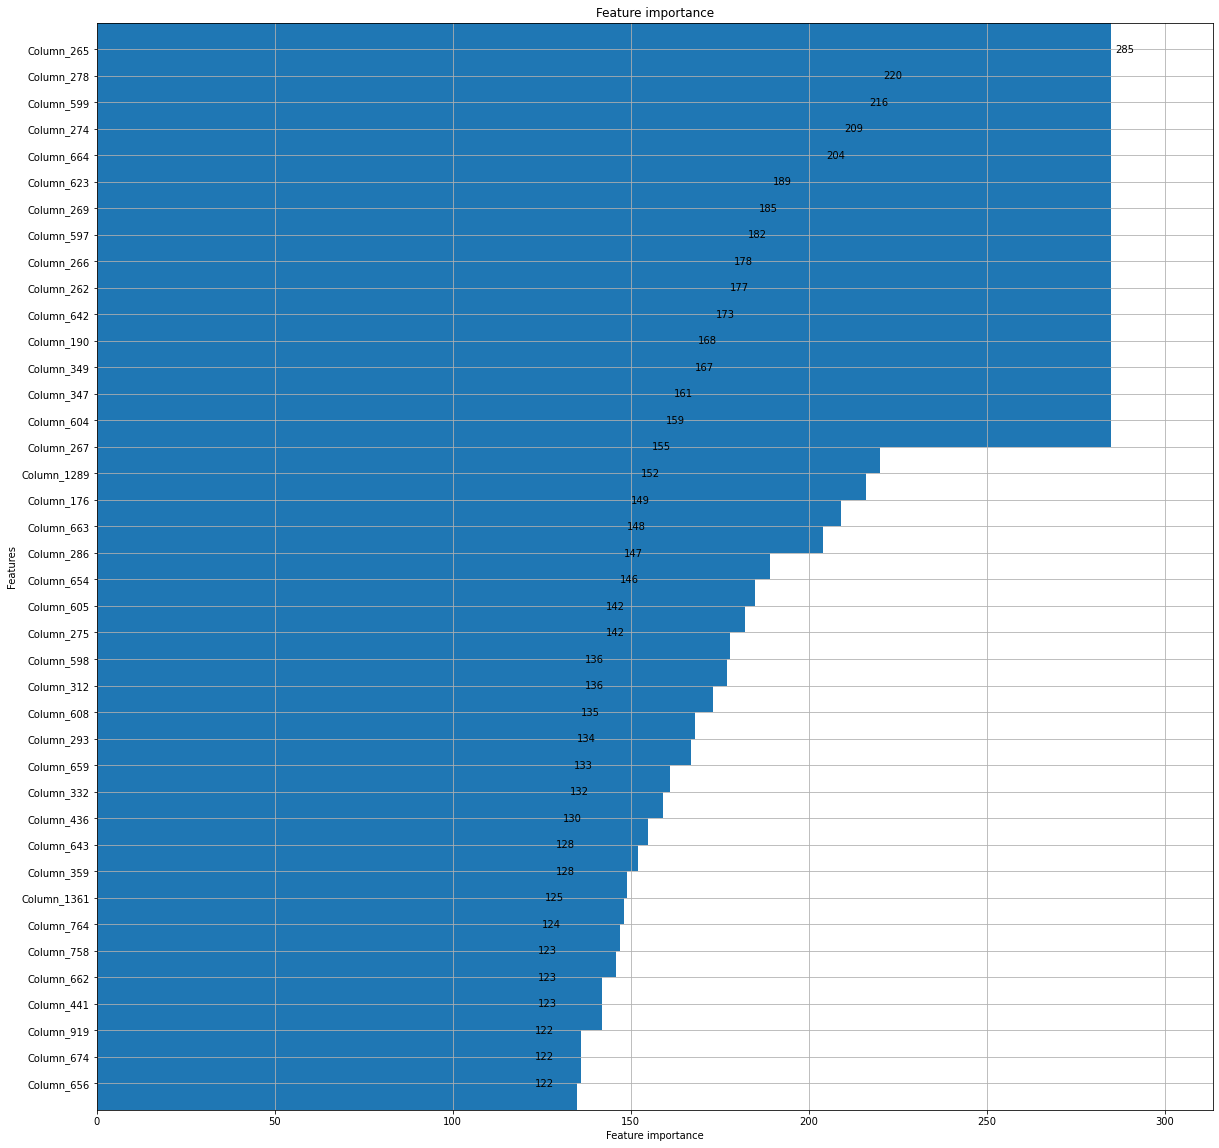

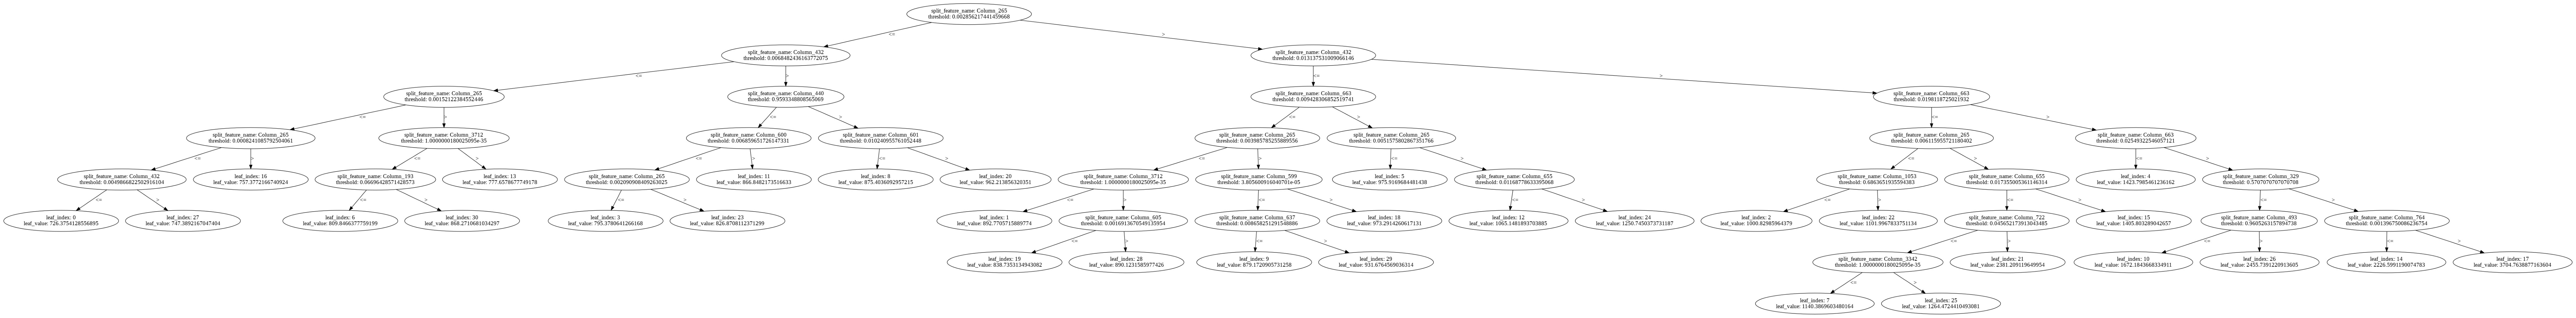

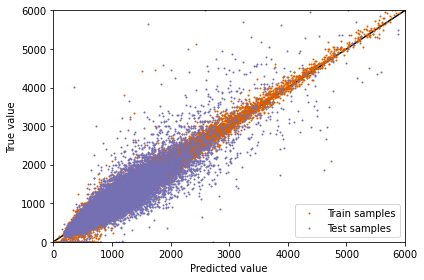

In [29]:
#### The output only represents our final model ####

date_time = datetime.now().strftime("%m_%d_%Y__%H_%M_%S")
# https://github.com/scikit-optimize/scikit-optimize/issues/723
# https://github.com/scikit-optimize/scikit-optimize/issues/964

search = BayesSearchCV(
    estimator = pipeline, 
    search_spaces = lgb_search_spaces, # xgb_search_space, # cat_search_space
    n_iter = 1 , #x models
    cv = 10, #does x validation splits
    verbose=10, # show everything
    random_state=random_state, 
    # n_jobs = -1, #use all processors # no propper output + laggs in google colab
    
    scoring = make_scorer(my_custom_score_rmse), #'neg_root_mean_squared_error', # 
    return_train_score=True,
    )

################################################################################
# Fit the random search model
if scikit_optimize_search_experiment:
  search.fit(X_train,y_train)
                                     


entry = {}
entry['Estimator'] = rf.__class__.__name__

################################################################################
# Predicting 
Y_test_pred = search.predict(X_test)
Y_test_pred_wo = search.predict(X_test_wo) 
Y_train_pred = search.predict(X_train)

################################################################################
# Testing 
# # Calculate your score on the predictions with respect to actual values
print("Test scores: ","\n",
      "R2: ", my_custom_r2(y_test, Y_test_pred), "\n",
      "RMSE: ", my_custom_score_rmse(y_test, Y_test_pred)*(-1), "\n",
      "ESS: ", my_custom_score_ev(y_test, Y_test_pred), "\n", # explained sum of squares
      )
print("Test scores (without outlier): ","\n",
      "R2: ", my_custom_r2(y_test_wo, Y_test_pred_wo), "\n",
      "RMSE: ", my_custom_score_rmse(y_test_wo, Y_test_pred_wo)*(-1), "\n",
      "ESS: ", my_custom_score_ev(y_test_wo, Y_test_pred_wo), "\n", # explained sum of squares
      )

#save all in entry and the pickle it
entry['R2'] = my_custom_r2(y_test, Y_test_pred)
entry['RMSE'] = my_custom_score_rmse(y_test, Y_test_pred)*(-1), 
entry['ESS'] = my_custom_score_ev(y_test, Y_test_pred),

# save other params
print("best score training: ",search.best_score_)
entry['R2_train'] = search.best_score_

print("best parameter: ",search.best_params_)
entry['get_params'] = search.best_params_

# parameter sapce
entry['parameter_space'] = xgb_search_spaces


print("best pipeline:",search.best_estimator_,"\n") # pipeline + model explanation
# entry['best_estimator_'] = search.best_estimator_

entry['SearchCV'] = search  

  


# # https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/
# matbplotlib plots
model_best = search.best_estimator_

if entry['Estimator'] == 'LGBMRegressor':
  # if we do use PolynomialFeatures:
  if str(model_best[1]) == 'PolynomialFeatures()':
    plt1 = lgb.plot_importance(model_best[2], height =30, max_num_features = 40,figsize=(20,20))
    plt2 = lgb.plot_tree(model_best[2],figsize=(150,150))
  # if we do not use PolynomialFeatures:
  else:
    plt1 = lgb.plot_importance(model_best[1], height =30, max_num_features = 40,figsize=(20,20))
    plt2 = lgb.plot_tree(model_best[1],figsize=(150,150))



pdList = [pd.DataFrame(search.cv_results_['params']),pd.DataFrame(search.cv_results_['mean_fit_time'],columns=['mean_fit_time']),pd.DataFrame(search.cv_results_['mean_test_score']*(-1),columns=['mean_test_score'])]  # List of your dataframes
          # pd.DataFrame(search.cv_results_['mean_test_RMSE'],columns=['mean_test_RMSE']),pd.DataFrame(search.cv_results_['mean_test_r2'],columns=['mean_test_r2']) ]  # List of your dataframes
df_results_cv = pd.concat(pdList, axis=1)
entry['CV_Results_Parameter_and_scores'] = df_results_cv
print("\n", "Best experiments:")
display(df_results_cv.head(20).sort_values('mean_test_score',ascending=False))
print("\n", "Worst experiments:")
display(df_results_cv.head(20).sort_values('mean_test_score',ascending=True))

print("Final estimator: \n",entry['Estimator'])

# create fodler  
try:
    save_path = os.path.join(CURRENT_DIR, 'Models','scikit_optimize_Full_LGB',str(date_time))
    os.mkdir(save_path)
except OSError:
    pass

################################################################################
# save it all: 
# save model
# joblib.dump(rf_random.best_estimator_, os.path.join(save_path, '{}_R2_{}.pkl'.format(entry['Estimator'] ,entry['R2'].round(3))) , compress = 1)
with open(os.path.join(save_path, '{}_R2_{}.pkl'.format(entry['Estimator'] ,entry['R2'].round(3))), 'wb') as handle:
  pickle.dump(search.best_estimator_, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save all other matrix
with open(os.path.join(save_path, '{}_Matrix.pkl'.format(entry['Estimator'],entry['R2'])), 'wb') as handle:
  pickle.dump(entry, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save matplotlib figures
if entry['Estimator'] == 'LGBMRegressor':
  plt1.figure.savefig(os.path.join(save_path, 'lgb_feature_importance.png'))
  plt2.figure.savefig(os.path.join(save_path, 'lgb_decision_criteria.png'))
  plt.show()

# create true vs. pred
plt3 = plt.scatter(Y_train_pred, y_train, label="Train samples", c='#d95f02',s=1)
plt3 = plt.scatter(Y_test_pred , y_test, label="Test samples", c='#7570b3',s=1)
plt3 = plt.xlabel("Predicted value")
plt3 = plt.ylabel("True value")
plt3 = plt.legend()
plt3 = plt.plot([0, 6000], [0, 6000], c='k', zorder=0)
plt3 = plt.xlim([0, 6000])
plt3 = plt.ylim([0, 6000])
plt3 = plt.tight_layout()
plt3 = plt.rcParams["figure.figsize"] = (8,8)
plt3 = plt.savefig(os.path.join(save_path, 'lgb_true_vs_prediction.png'), dpi=100)


# Shap (XAI Framework) https://github.com/slundberg/shap 

## Best result from scikit-optimize

In [30]:
import sklearn
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]
        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names


In [31]:
path = 'scikit_optimize_Full_LGB/12_23_2021__12_06_13'
model = 'LGBMRegressor_R2_0.66.pkl'
with open(os.path.join('drive/MyDrive/IE_500_Data_Mining_I/MachineLearning/Models/{}'.format(path), model),'rb') as handle:
    model_shap = pickle.load(handle)
with open(os.path.join('drive/MyDrive/IE_500_Data_Mining_I/MachineLearning/Models/{}'.format(path),'LGBMRegressor_Matrix.pkl'),'rb') as handle:
    c = pickle.load(handle)
print(c)

{'Estimator': 'LGBMRegressor', 'R2': 0.6602243747442176, 'RMSE': (377.3449395050185,), 'ESS': (0.6602258715587452,), 'R2_train': -224.9771621316322, 'get_params': OrderedDict([('rf__learning_rate', 0.2), ('rf__min_child_samples', 5), ('rf__n_estimators', 1000), ('t__degree', 2), ('transform__num__scale', MaxAbsScaler())]), 'parameter_space': {'transform__num__scale': [MinMaxScaler(), MaxAbsScaler(), StandardScaler()], 'rf__learning_rate': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3]}, 'SearchCV': BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('transform',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('impute',
                                                                                           SimpleImputer()),
                                                                                        

In [32]:
X_train_features = get_feature_names(model_shap[0])
X_train_features_with_polynominal = model_shap[1].get_feature_names(X_train_features) 

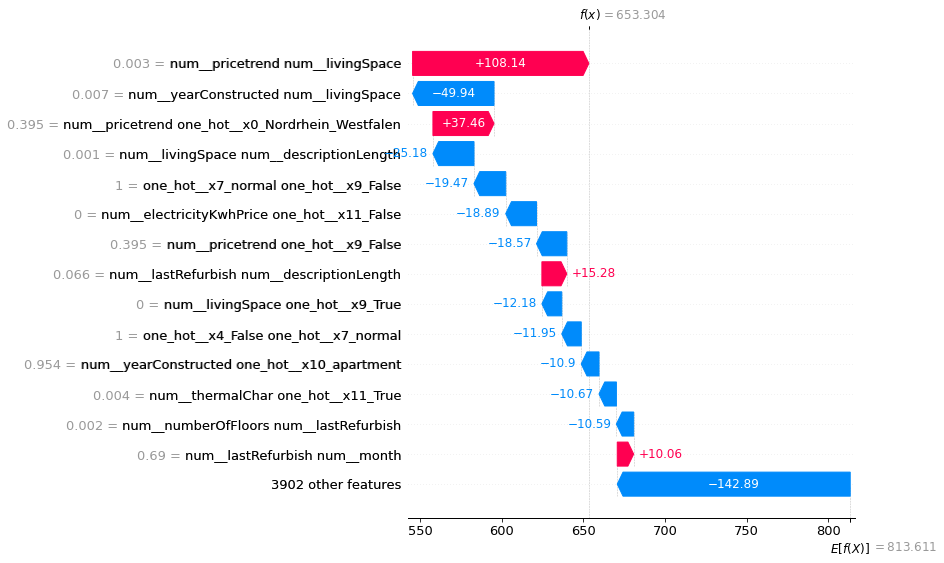

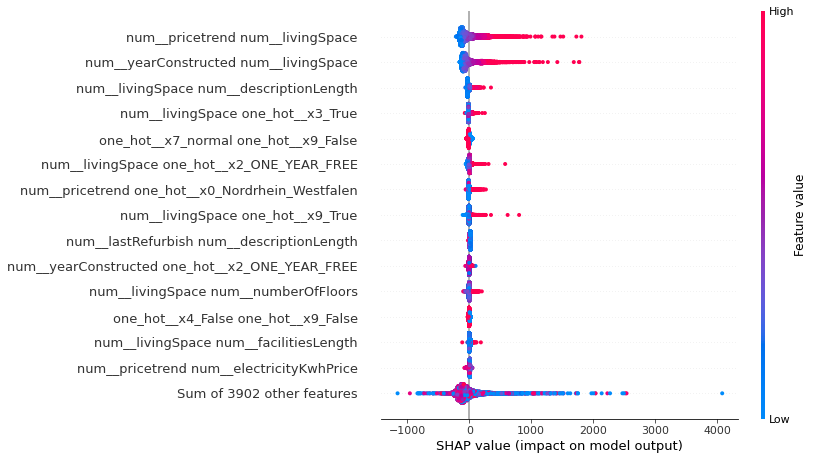

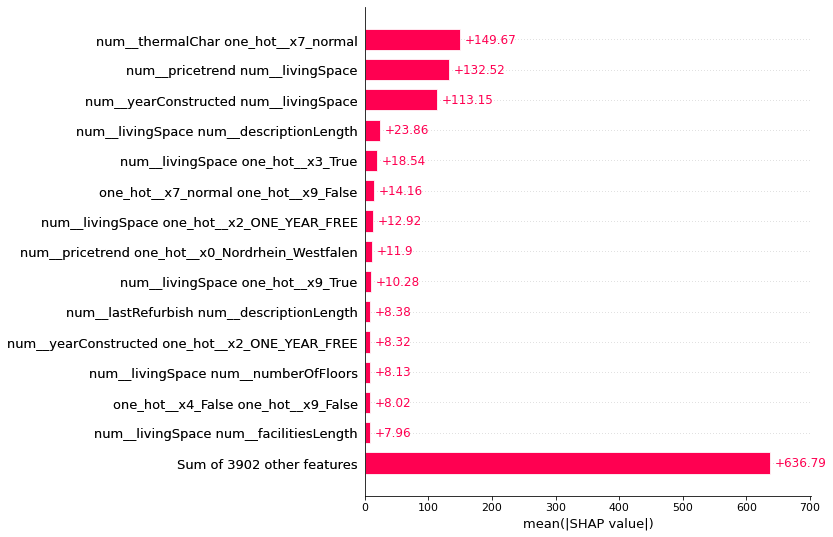

In [33]:
X_train_sample = X_train.sample(10000)
# transformation Imputer Scaler and Onehotencoding
X_train_sample_transformed = model_shap[0].transform(X_train_sample)
X_train_sample_transformed_df = pd.DataFrame(X_train_sample_transformed, columns = X_train_features)
# transformation polynominal
X_train_sample_transformed_pol =  model_shap[1].transform(X_train_sample_transformed_df)
X_train_sample_transformed_df_pol = pd.DataFrame(X_train_sample_transformed_pol, columns = X_train_features_with_polynominal)

# use subsample (10k)
explainer = shap.Explainer(model_shap[2])
shap_values_train = explainer(X_train_sample_transformed_df_pol)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values_train[0], max_display=15)
shap.plots.beeswarm(shap_values_train, max_display=15)
shap.plots.bar(shap_values_train, max_display=15)

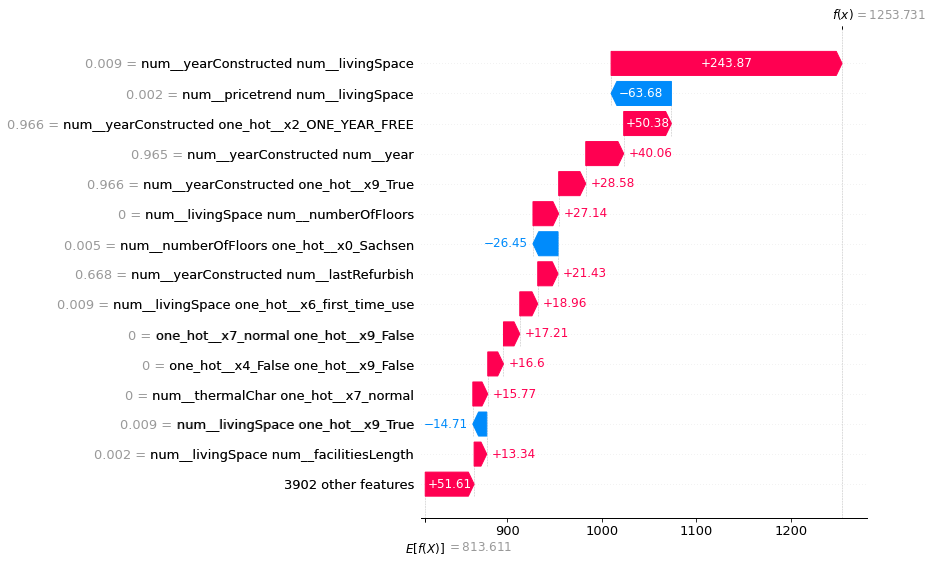

<Figure size 576x576 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt

X_test_sample = X_test.sample(10000)
X_test_sample_transformed = model_shap[0].transform(X_test_sample)
X_test_sample_transformed_df = pd.DataFrame(X_test_sample_transformed, columns = X_train_features)
X_test_sample_transformed_pol =  model_shap[1].transform(X_test_sample_transformed_df)
X_test_sample_transformed_df_pol = pd.DataFrame(X_test_sample_transformed_pol, columns = X_train_features_with_polynominal)

# use subsample (10k)
explainer = shap.Explainer(model_shap[2])
shap_values_test = explainer(X_test_sample_transformed_df_pol)
# visualize the first prediction's explanation

shap.plots.waterfall(shap_values_test[0], max_display=15)
f = plt.gcf()
plt.savefig(os.path.join('drive/MyDrive/IE_500_Data_Mining_I/MachineLearning/Models/{}'.format(path), "Test_Waterfall_plot.png"))


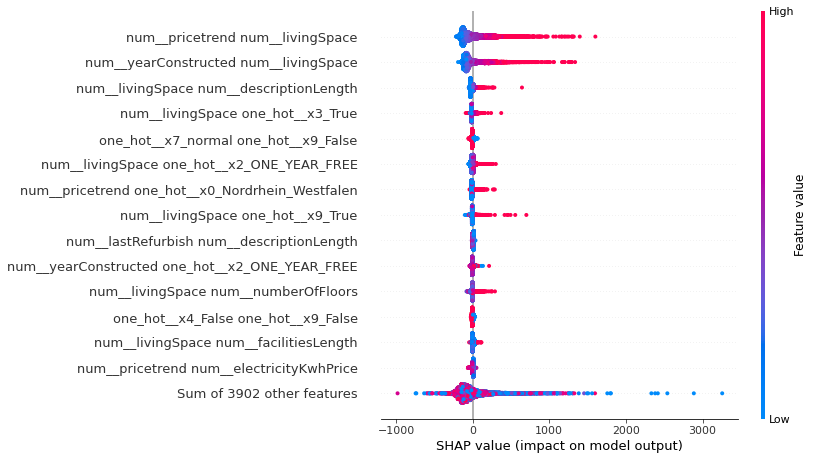

In [39]:
shap.plots.beeswarm(shap_values_test, max_display=15,show=False)
f = plt.gcf()
plt.savefig(os.path.join('drive/MyDrive/IE_500_Data_Mining_I/MachineLearning/Models/{}'.format(path), "Test_Beeswarm_plot.png"))

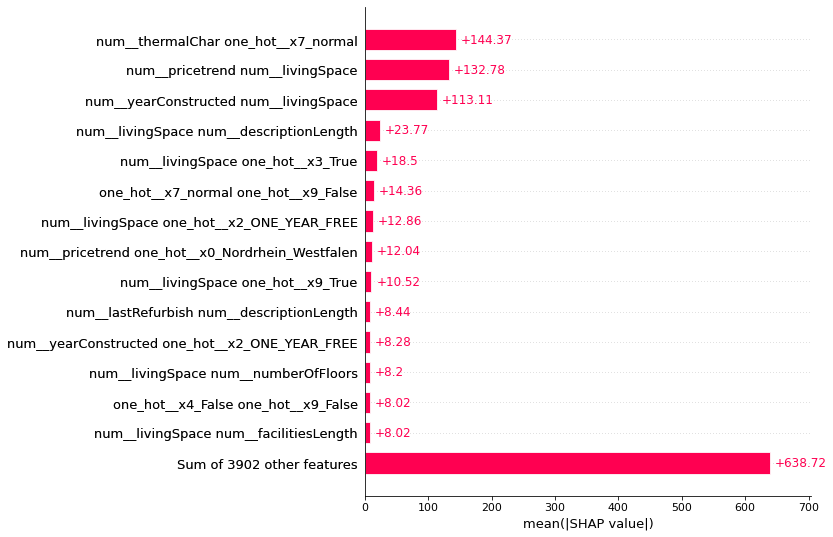

In [40]:
shap.plots.bar(shap_values_test, max_display=15, show=False)
f = plt.gcf()
plt.savefig(os.path.join('drive/MyDrive/IE_500_Data_Mining_I/MachineLearning/Models/{}'.format(path), "Test_Bar_plot.png"))